1. Import Dependencies

In [37]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

2. Load & Inspect Data

In [40]:
FNAME = "Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"
df = pd.read_csv(FNAME)

# Convert first column to datetime and set as index
df['Date'] = pd.to_datetime(df[df.columns[0]])
df = df.set_index('Date').sort_index()

# Select service types
service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
df_services = df[service_types]

# Inspect data
print(df_services.head())
print(df_services.describe())

            Local Route  Light Rail  Peak Service  Rapid Route  School
Date                                                                  
2019-07-01        15987        9962           407        21223    3715
2019-07-02        16895       10656           409        21715    3993
2019-07-03        16613       10658           427        22025    3638
2019-07-04        16604       10445           437        21868    3576
2019-07-05        16040       10532           400        20697    2856
        Local Route    Light Rail  Peak Service   Rapid Route       School
count   1918.000000   1918.000000   1918.000000   1918.000000  1918.000000
mean    9891.395203   7195.446298    179.581335  12597.213243  2352.694995
std     6120.715714   3345.616428    156.532738   6720.494557  2494.766306
min        1.000000      0.000000      0.000000      0.000000     0.000000
25%     3044.500000   4463.500000      0.000000   6383.000000     0.000000
50%    11417.000000   7507.000000    193.000000  1310

3. Data Cleaning

In [42]:
df_services = df_services.apply(lambda x: x.mask(x<0).interpolate(method='time').fillna(method='ffill').fillna(method='bfill'))

4. Exploratory Data Analysis

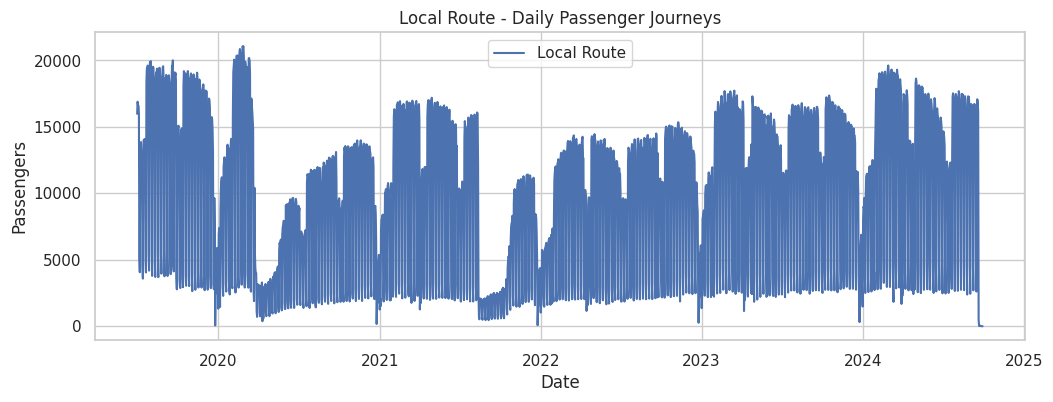

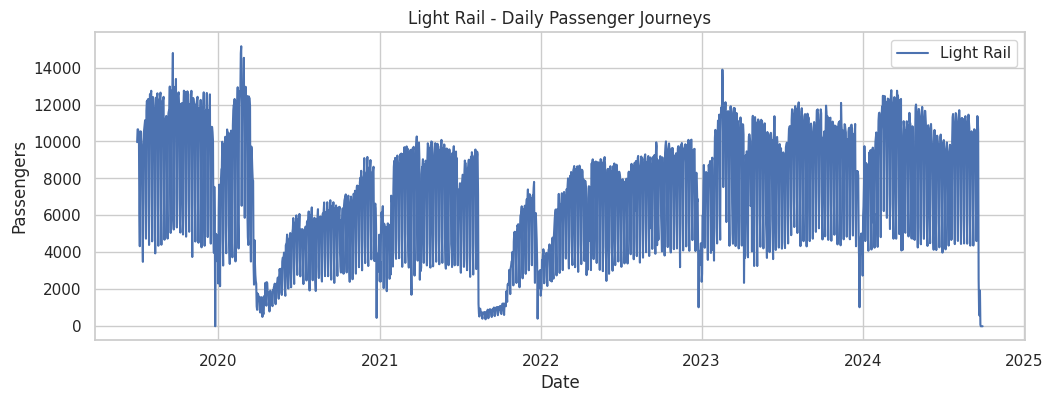

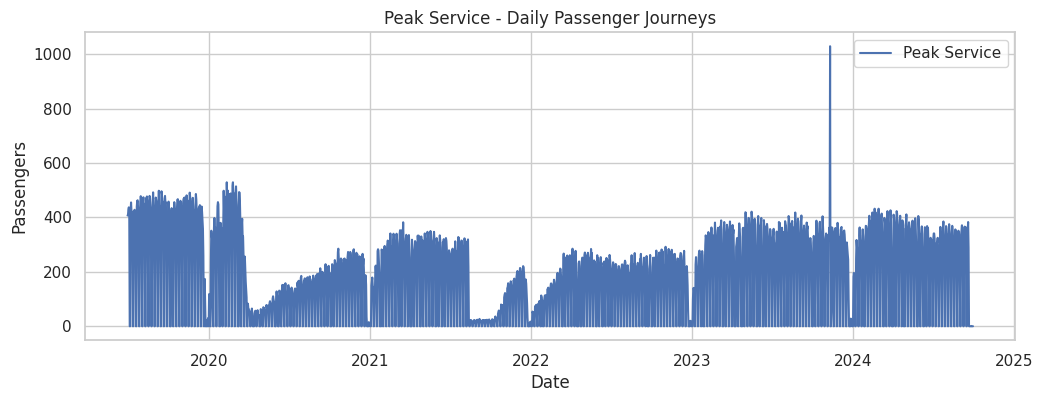

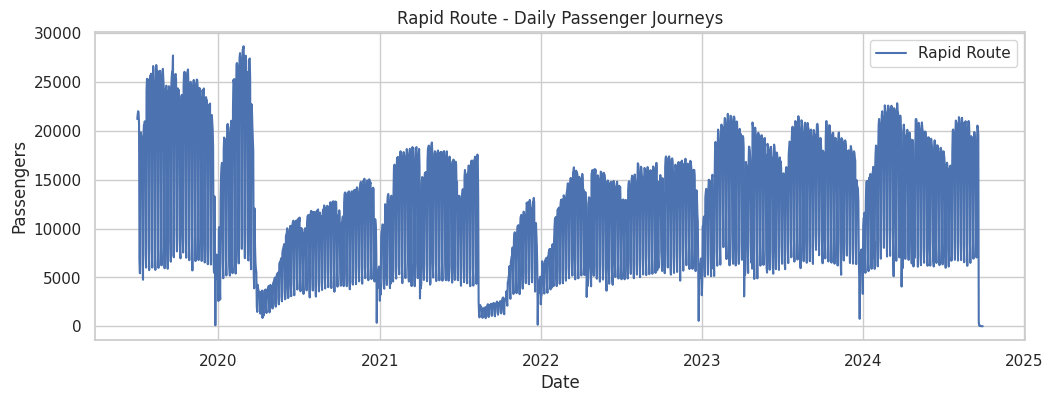

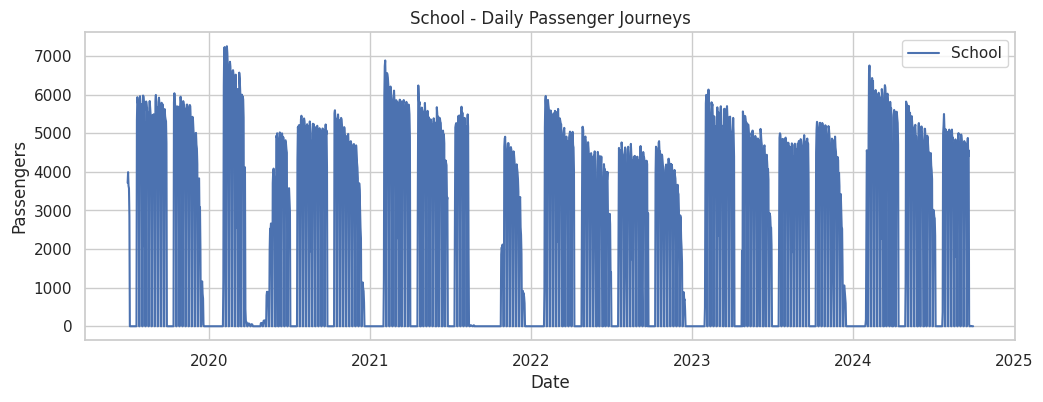

In [45]:
for col in service_types:
    plt.figure(figsize=(12,4))
    plt.plot(df_services[col], label=col)
    plt.title(f"{col} - Daily Passenger Journeys")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.show()

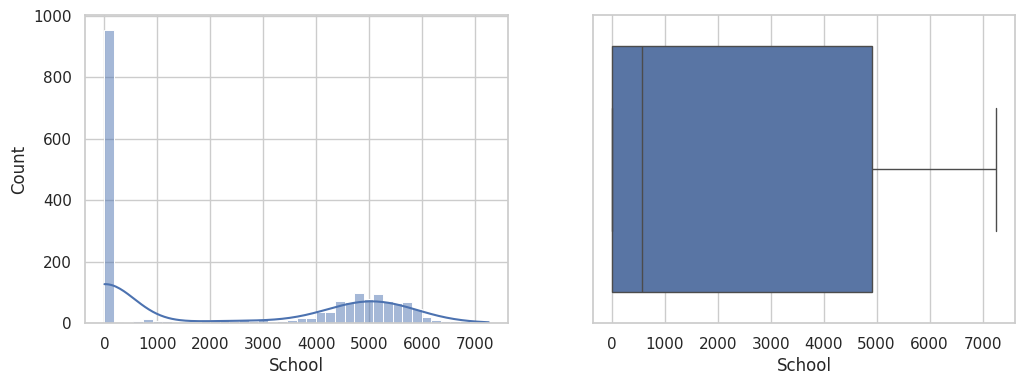

In [44]:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df_services[col], bins=40, kde=True)
    plt.subplot(1,2,2)
    sns.boxplot(x=df_services[col])
    plt.show()


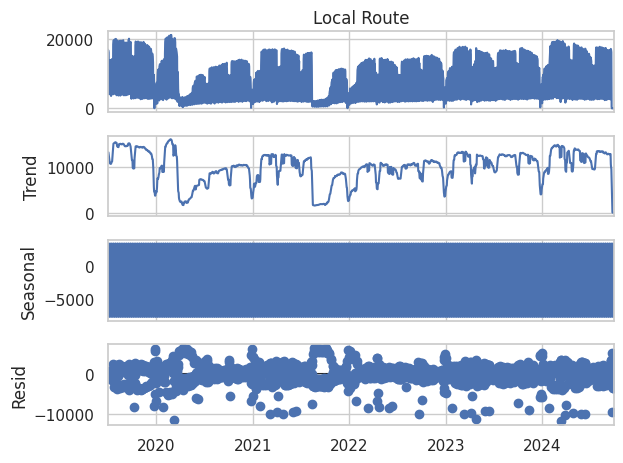

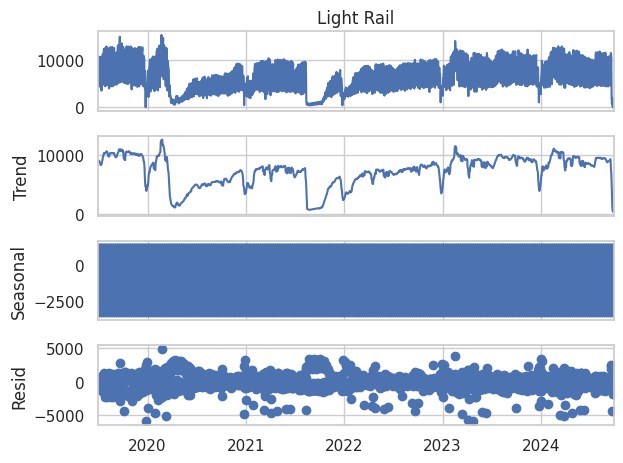

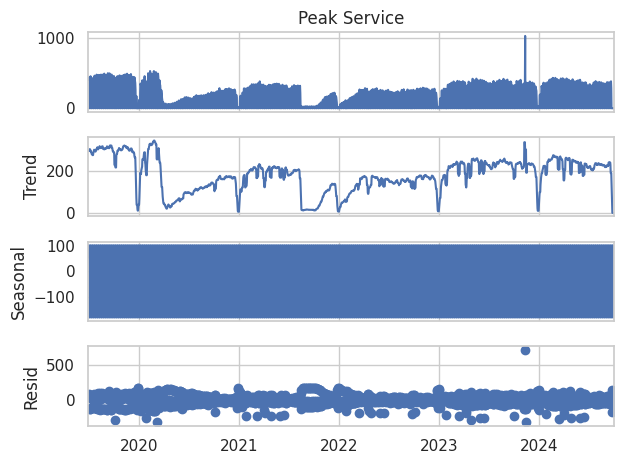

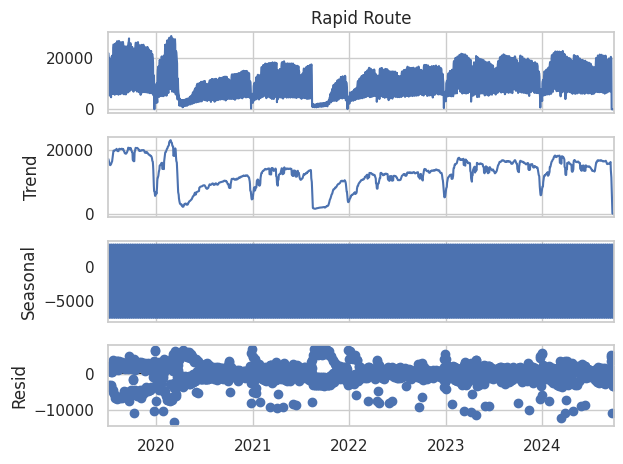

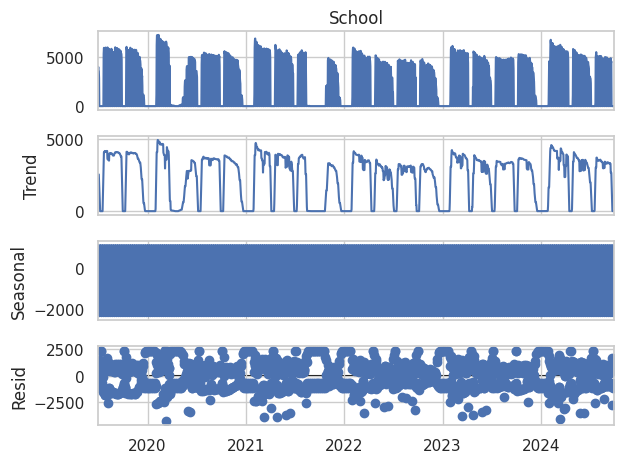

In [46]:
# Seasonal decomposition
for col in service_types:
    decomp = seasonal_decompose(df_services[col], model='additive', period=7)
    decomp.plot()
    plt.show()

5. Stationarity Test

In [47]:
def adf_test(series):
    res = adfuller(series.dropna(), autolag='AIC')
    print("ADF Statistic:", res[0])
    print("p-value:", res[1])

for col in service_types:
    print(f"\nADF Test - {col}")
    adf_test(df_services[col])


ADF Test - Local Route
ADF Statistic: -4.580035661257346
p-value: 0.00014056803698915072

ADF Test - Light Rail
ADF Statistic: -3.496058701403449
p-value: 0.008088893778396163

ADF Test - Peak Service
ADF Statistic: -3.870723309372977
p-value: 0.0022611898923561168

ADF Test - Rapid Route
ADF Statistic: -3.8281016528348717
p-value: 0.0026325357298384133

ADF Test - School
ADF Statistic: -7.133911909207525
p-value: 3.4605568058211924e-10


6. ACF/PACF Plots

<Figure size 1200x400 with 0 Axes>

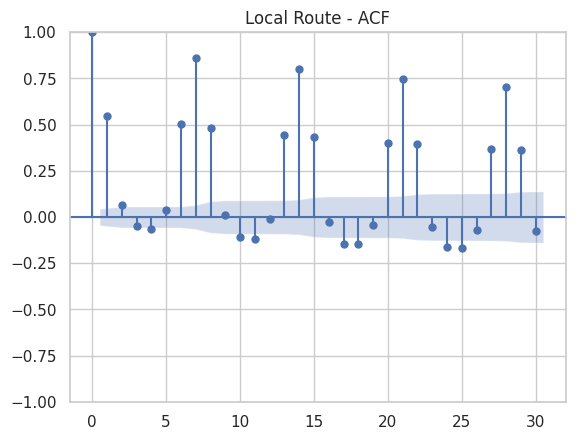

<Figure size 1200x400 with 0 Axes>

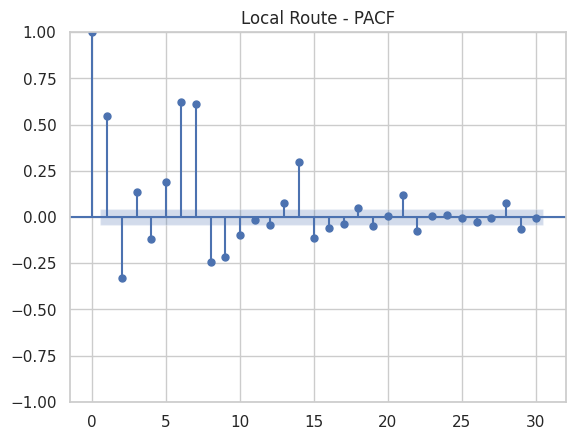

<Figure size 1200x400 with 0 Axes>

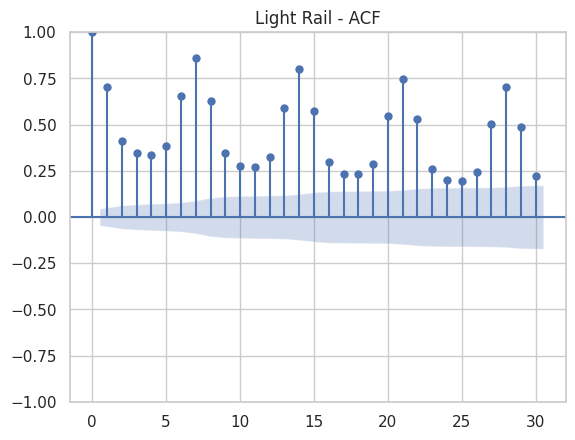

<Figure size 1200x400 with 0 Axes>

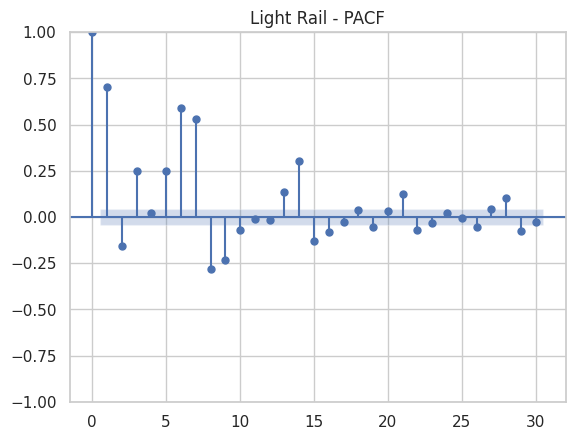

<Figure size 1200x400 with 0 Axes>

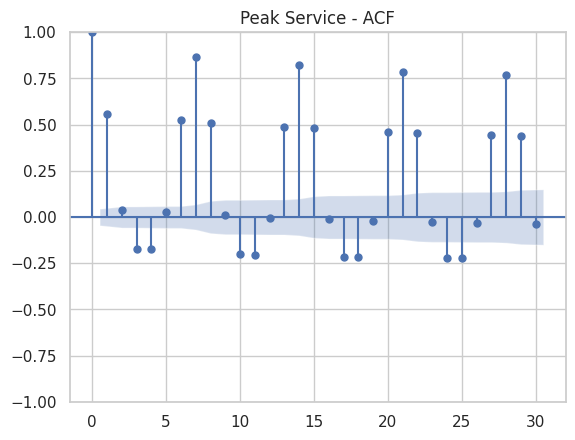

<Figure size 1200x400 with 0 Axes>

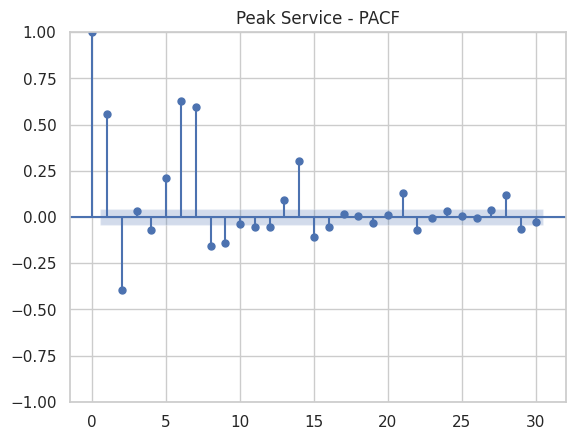

<Figure size 1200x400 with 0 Axes>

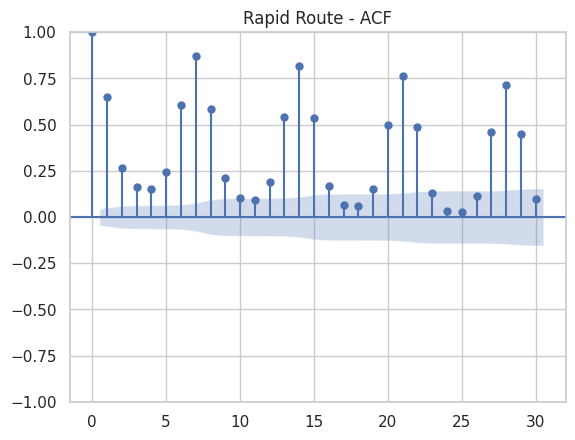

<Figure size 1200x400 with 0 Axes>

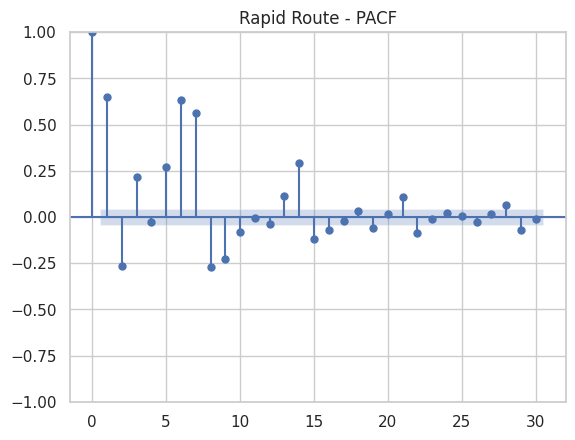

<Figure size 1200x400 with 0 Axes>

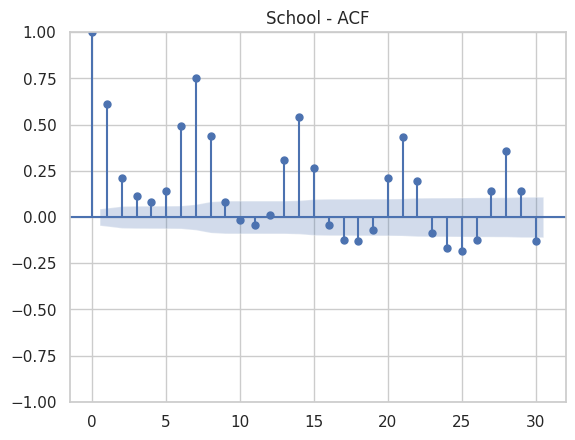

<Figure size 1200x400 with 0 Axes>

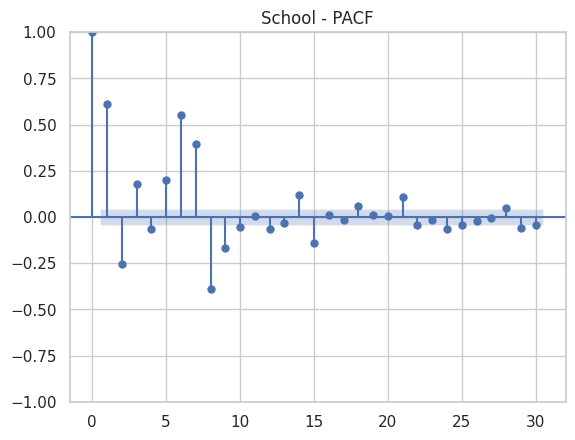

In [48]:
for col in service_types:
    plt.figure(figsize=(12,4))
    plot_acf(df_services[col], lags=30)
    plt.title(f"{col} - ACF")
    plt.show()

    plt.figure(figsize=(12,4))
    plot_pacf(df_services[col], lags=30, method='ywm')
    plt.title(f"{col} - PACF")
    plt.show()

7. Train/Test Split

In [49]:
HOLDOUT_DAYS = 30
train_services = df_services.iloc[:-HOLDOUT_DAYS]
test_services = df_services.iloc[-HOLDOUT_DAYS:]

8. SARIMA Forecast Function

In [50]:
def forecast_service(series, steps=7, seasonal_period=7, p=1,d=1,q=1,P=1,D=1,Q=1):
    series = series.copy()
    # Clean series
    series[series<0] = np.nan
    series = series.asfreq('D')
    series = series.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

    # Fit SARIMA
    model = SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    # Forecast
    forecast_res = res.get_forecast(steps=steps)
    y_forecast = pd.Series(forecast_res.predicted_mean.values,
                           index=pd.date_range(start=series.index[-1]+timedelta(days=1), periods=steps))
    ci = forecast_res.conf_int()

    return y_forecast, ci, res

9. 7-Day Forecast

In [52]:
forecast_results = {}
for service in service_types:
    y_pred, ci, model_res = forecast_service(df_services[service], steps=7)
    forecast_results[service] = y_pred

9. Evaluation

In [34]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true==0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred)/denom))*100

mae = mean_absolute_error(test['y'], y_pred)
rmse = np.sqrt(mean_squared_error(test['y'], y_pred))
mape_v = mape(test['y'], y_pred)
print(f"SARIMA -> MAE={mae:.3f}, RMSE={rmse:.3f}, MAPE={mape_v:.2f}%")

SARIMA -> MAE=4515.174, RMSE=7686.615, MAPE=56587.23%


10. Visualization

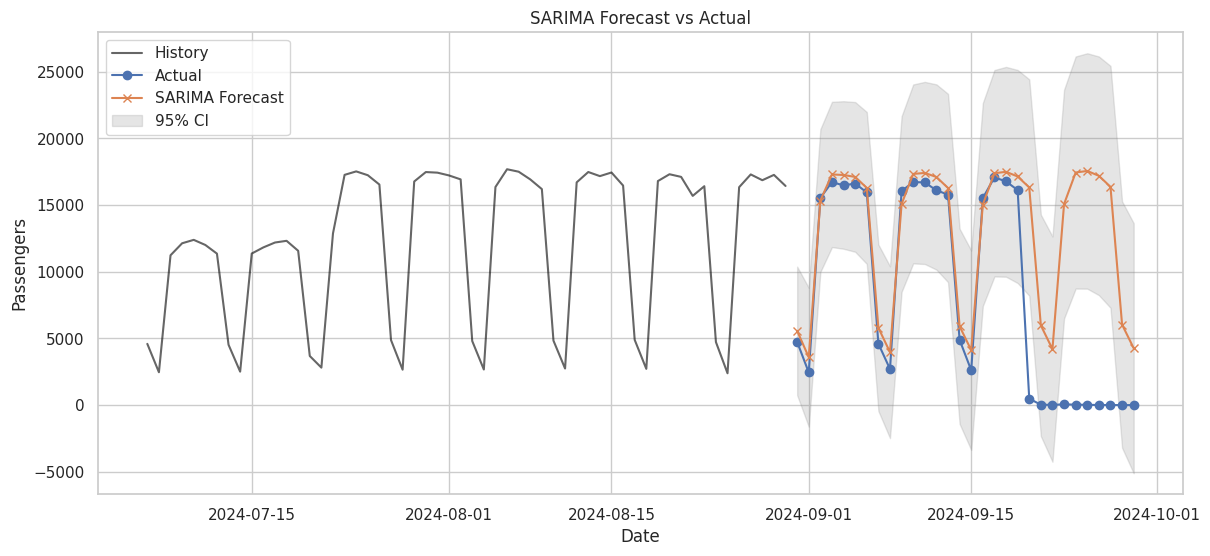

In [35]:
plt.figure(figsize=(14,6))
plt.plot(train.index[-56:], train['y'].tail(56), label='History', color='black', alpha=0.6)
plt.plot(test.index, test['y'], label='Actual', marker='o')
plt.plot(test.index, y_pred, label='SARIMA Forecast', marker='x')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.2, label='95% CI')
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

10. Evaluation

In [56]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

for service in service_types:
    train = train_services[service]
    test = test_services[service]
    y_pred_eval, _, _ = forecast_service(train, steps=HOLDOUT_DAYS)

    mae = mean_absolute_error(test, y_pred_eval)
    rmse = np.sqrt(mean_squared_error(test, y_pred_eval))
    smape_v = smape(test, y_pred_eval)

    print(f"{service} -> MAE={mae:.2f}, RMSE={rmse:.2f}, SMAPE={smape_v:.2f}%")

Local Route -> MAE=4515.17, RMSE=7686.62, SMAPE=73.74%
Light Rail -> MAE=3155.61, RMSE=5088.49, SMAPE=63.34%
Peak Service -> MAE=73.61, RMSE=135.79, SMAPE=110.32%
Rapid Route -> MAE=5959.23, RMSE=9686.70, SMAPE=70.89%
School -> MAE=1153.86, RMSE=1705.10, SMAPE=115.38%


11. Visualization

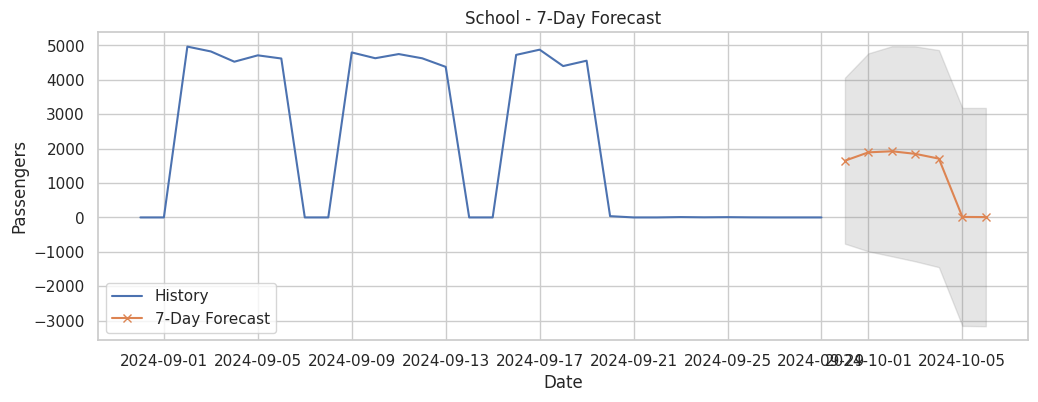

In [53]:
plt.figure(figsize=(12,4))
plt.plot(df_services[service][-30:], label="History")
plt.plot(y_pred, label="7-Day Forecast", marker='x')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.2)
plt.title(f"{service} - 7-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

12. Combine All Forecasts into One DataFrame

In [55]:
forecast_df = pd.DataFrame(forecast_results)
print("\nCombined 7-Day Forecast for All Services:")
print(forecast_df)


Combined 7-Day Forecast for All Services:
            Local Route   Light Rail  Peak Service  Rapid Route       School
2024-09-30  3896.785371  2349.691201    153.086729  3750.284369  1649.862046
2024-10-01  4399.216726  2386.912799    159.792135  4203.638648  1892.325593
2024-10-02  4170.407307  2326.404278    154.966548  3822.171599  1923.601610
2024-10-03  3830.040979  1998.235732    119.515123  3457.604918  1848.220100
2024-10-04  2853.942861  1113.799846     53.517173  1211.024043  1709.628663
2024-10-05 -3846.461433 -1902.860140   -104.753035 -4619.302192    14.723507
2024-10-06 -5017.471226 -3001.537546   -104.803912 -5711.856674    10.108979
